In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from kmedoids import fasterpam
from ripser import ripser
from persim import plot_diagrams
from tqdm import tqdm
from time import time

from yao_utils_otra import *
from atlas_pam import atlas_pam

Computing brute matrix...


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 257.95it/s]

Done


In [2]:
data_dir = "data/sphere"
X = np.load(data_dir+"/sphere_uniform_1000.npy")

In [3]:
sphere_eps = 1e-6
n_radii = 100
n_thetas = 100

def draw_sphere(ax, alpha=0.3):
    radii = np.linspace(sphere_eps, 1.0, n_radii)
    thetas = np.linspace(0, 2*np.pi, n_thetas)
    Radii, Thetas = np.meshgrid(radii, thetas)
    sinT = np.sin(Thetas)
    cosT = np.cos(Thetas)
    X = Radii * cosT
    Y = Radii * sinT
    Z_pre = np.zeros(X.shape)
    Z = np.sqrt(np.max([1 - X**2 - Y**2, Z_pre], axis=0))
    Z_neg = - Z
    
    ax.plot_surface(X, Y, Z, alpha=alpha, color="grey")
    ax.plot_surface(X, Y, Z_neg, alpha=alpha, color="grey")

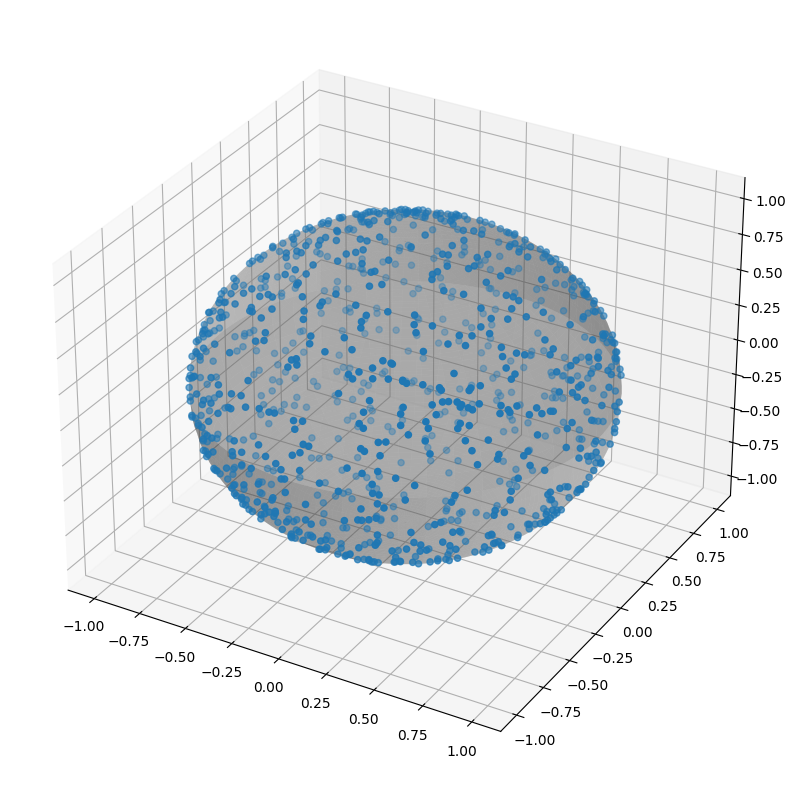

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
draw_sphere(ax)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

plt.show()

In [5]:
ac = atlas_pam(X, 2, 10)

Getting graph as sparse matrix...
Done
Getting graph from sparse matrix...
Done
Generating distance matrix...


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [43:20<00:00,  2.60s/it]


Done


In [6]:
def draw_total_on_sphere():
    # Get points from each chart
    Xs = []
    for ind in tqdm(range(ac.n_charts)):
        X = ac.sample_uniformly_from_chart_by_ind(ind, grid_len=10)
        Xs.append(X)
    X = np.vstack(Xs)
    # Draw points in spherical representation
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    draw_sphere(ax)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    # Show graphic
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 428.13it/s]


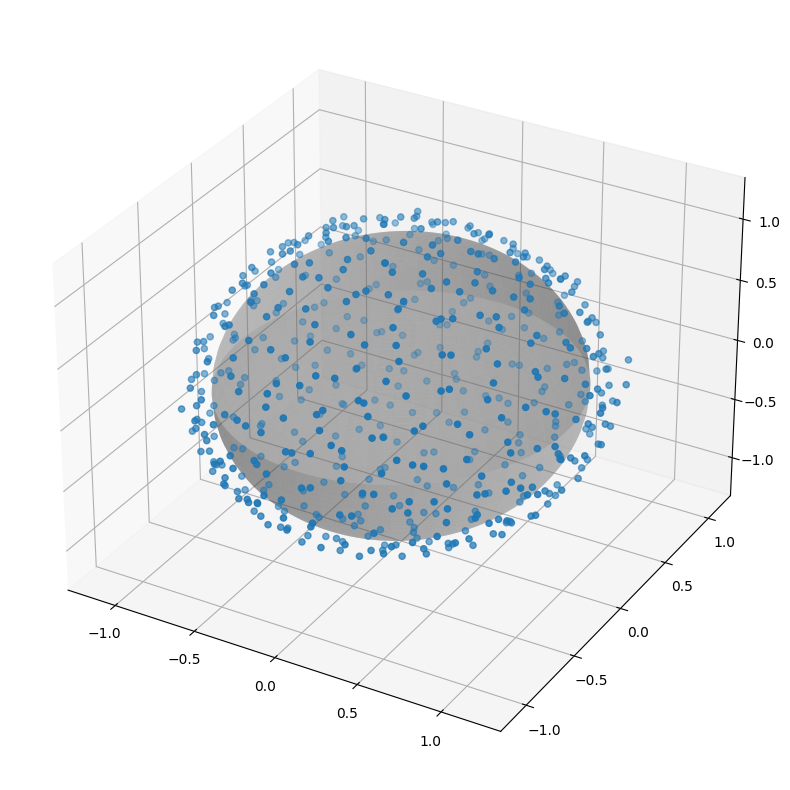

In [7]:
draw_total_on_sphere()

In [8]:
# Recreate axial rings from atlas graph
n_pts = 100
xis_xy = []
inds_xy = []
for theta in tqdm(np.linspace(0, 2*np.pi, n_pts)):
    x = np.array([np.cos(theta), np.sin(theta), 0.0])
    print(x)
    xi, ind = ac.ingest_ambient_point(x)
    print(xi)
    print(ind)
    x_prime = ac.xi_ind_to_ambient(xi, ind)
    print(x_prime)
    goober = ac.chart_dict[ind]
    for item in goober:
        print(item)
    print("\n")
    xis_xy.append(xi)
    inds_xy.append(ind)

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 986.14it/s]

[1. 0. 0.]
[0.19123763 0.40963697]
7
[ 1.0605831  -0.01156339  0.02325994]
[ 0.89469612 -0.17578236  0.41063294]
[[ 0.14637753  0.36587195]
 [-0.67940551  0.71248491]
 [-0.71901444 -0.59875118]]
[[-0.91908179]
 [ 0.1754235 ]
 [-0.3528672 ]]
1.020584861399099
[[-0.10418954]
 [ 0.56722222]
 [ 0.00725621]
 [ 0.5715777 ]]


[0.99798668 0.06342392 0.        ]
[0.14785236 0.45408894]
7
[1.05807079 0.05195577 0.02306837]
[ 0.89469612 -0.17578236  0.41063294]
[[ 0.14637753  0.36587195]
 [-0.67940551  0.71248491]
 [-0.71901444 -0.59875118]]
[[-0.91908179]
 [ 0.1754235 ]
 [-0.3528672 ]]
1.020584861399099
[[-0.10418954]
 [ 0.56722222]
 [ 0.00725621]
 [ 0.5715777 ]]


[0.99195481 0.12659245 0.        ]
[0.10405238 0.49688867]
7
[1.05179198 0.11517144 0.02297355]
[ 0.89469612 -0.17578236  0.41063294]
[[ 0.14637753  0.36587195]
 [-0.67940551  0.71248491]
 [-0.71901444 -0.59875118]]
[[-0.91908179]
 [ 0.1754235 ]
 [-0.3528672 ]]
1.020584861399099
[[-0.10418954]
 [ 0.56722222]
 [ 0.00725621]
 [ 0.57157

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 635.78it/s]


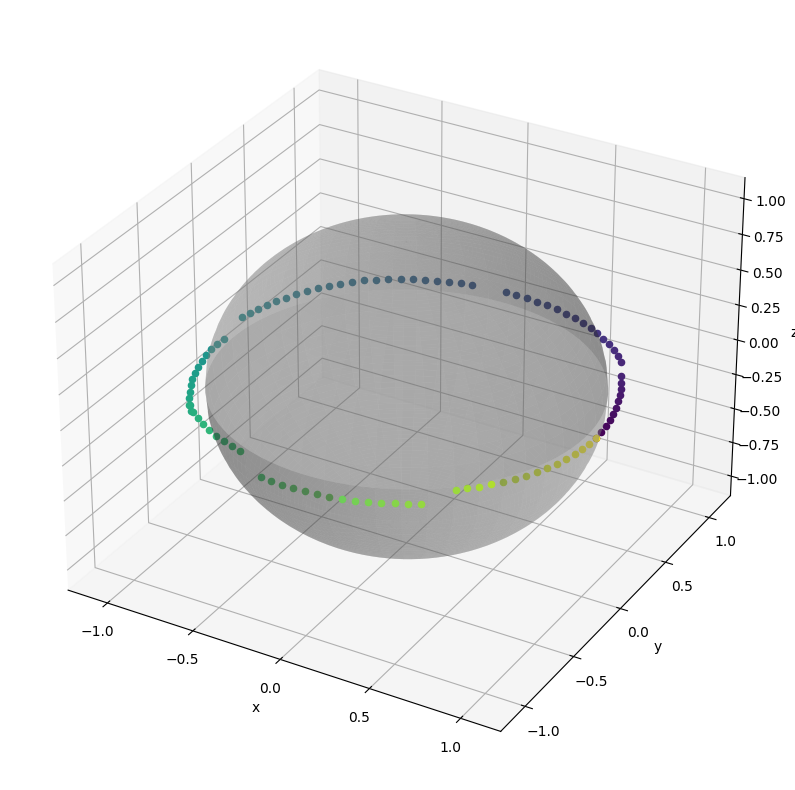

In [9]:
# Recreate ring from atlas graph
pts_xy = []
for xi, ind in zip(xis_xy, inds_xy):
    x = ac.xi_ind_to_ambient(xi, ind)
    pts_xy.append(x)
pts_xy = np.vstack(pts_xy)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")

draw_sphere(ax)

rgb_map = colormaps["viridis"]

#for ind in tqdm(range(n_pts)):
for ind in tqdm(range(100)):
    rgb = rgb_map(ind / n_pts)[:-1]
    ax.scatter(pts_xy[ind, 0], pts_xy[ind, 1], pts_xy[ind, 2],
              color=rgb)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

x_2, L_2, M_2, rad_2, h_mat_2 = ac.chart_dict[2]
x_3, L_3, M_3, rad_3, h_mat_3 = ac.chart_dict[3]

print(x_2)

In [10]:
def draw_chart_on_sphere(ind):
    # Get points from chart
    X = ac.sample_uniformly_from_chart_by_ind(ind, grid_len=10)
    # Draw points in spherical representation
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection="3d")
    draw_sphere(ax)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2])
    # Show graphic
    plt.show()

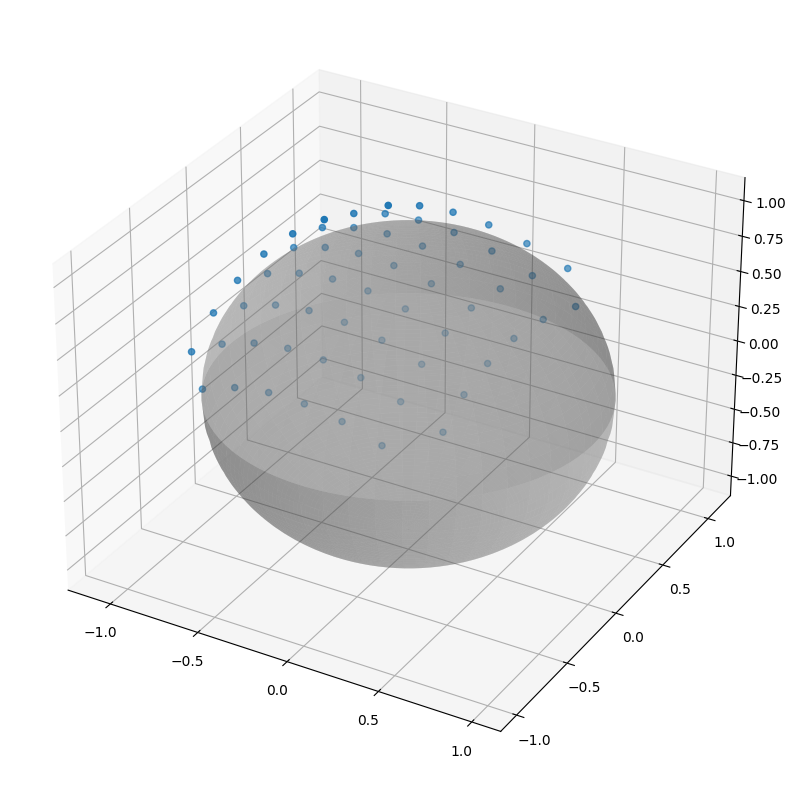

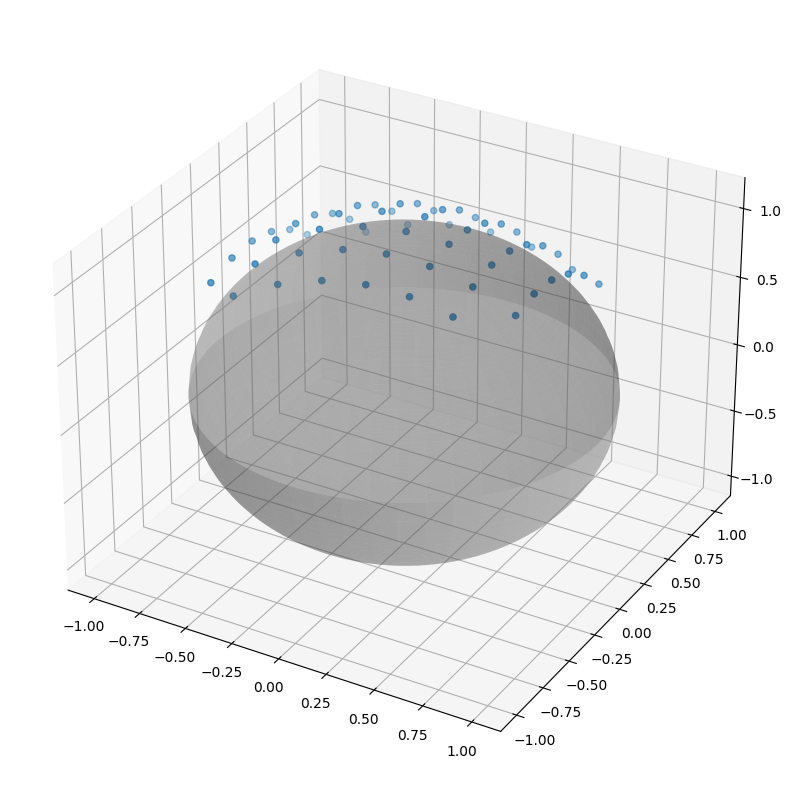

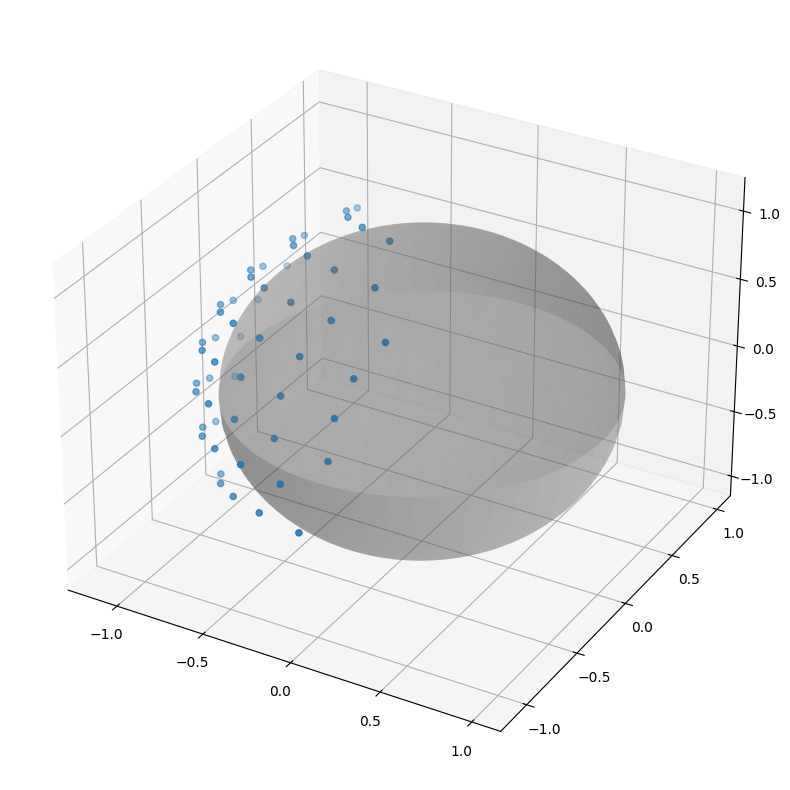

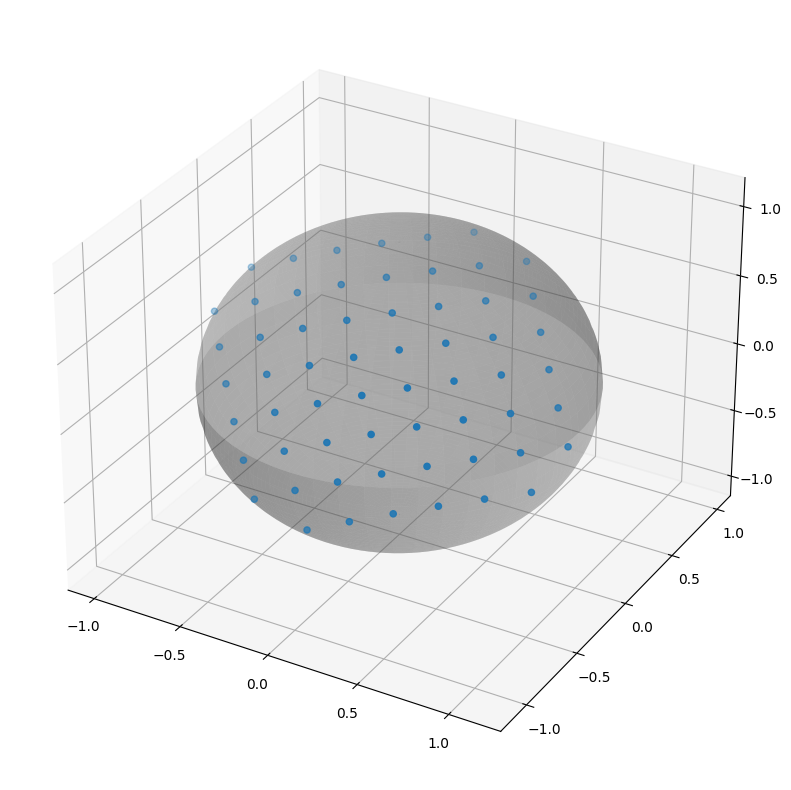

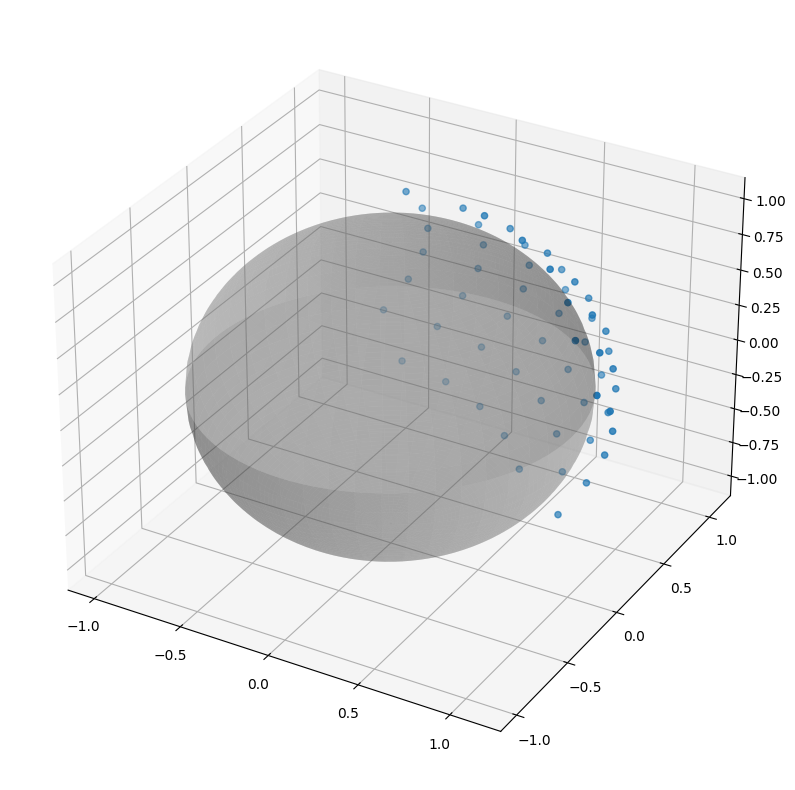

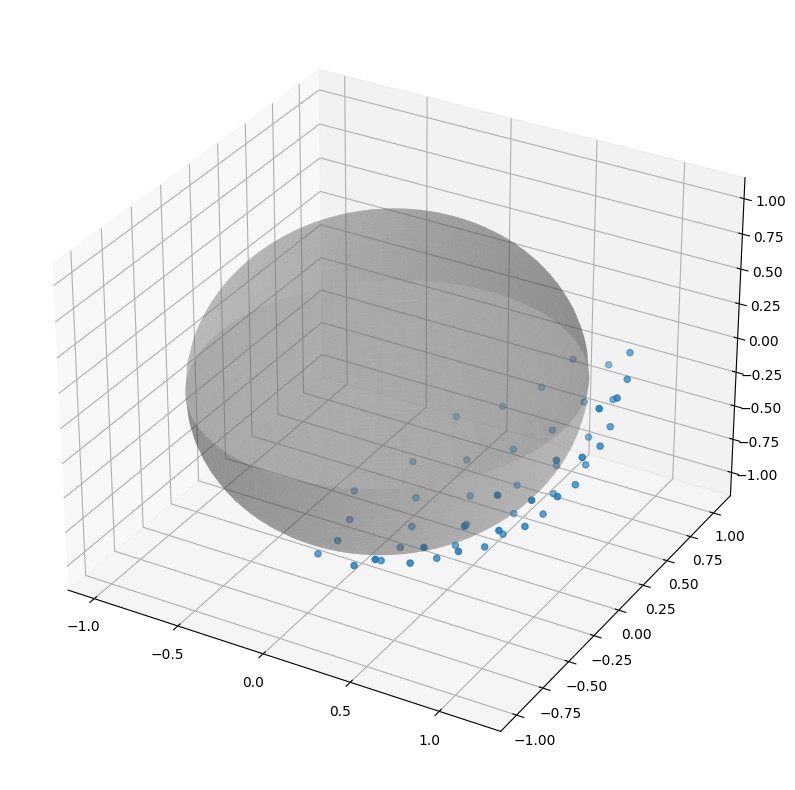

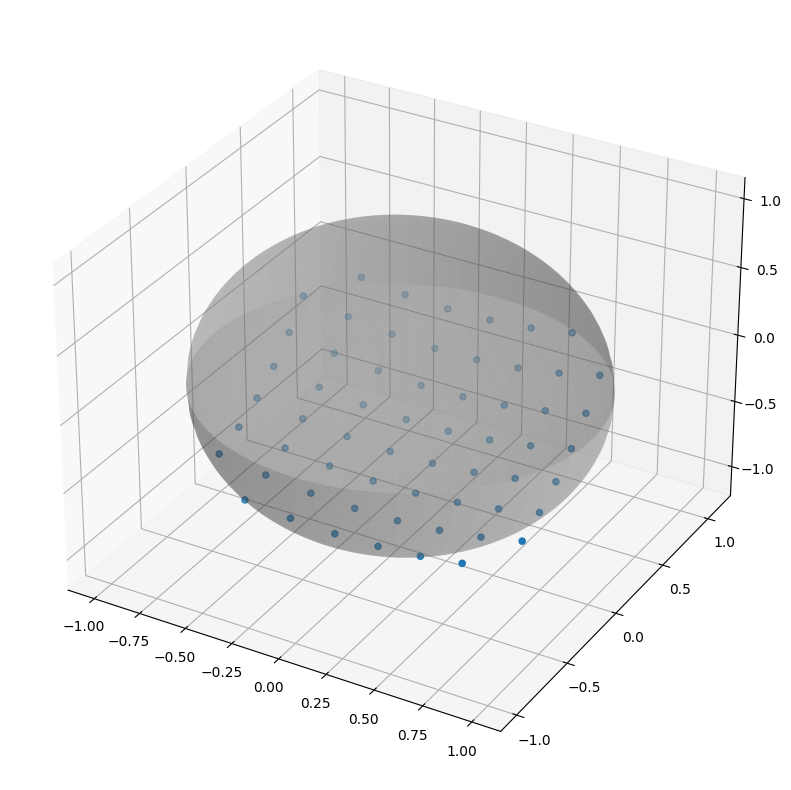

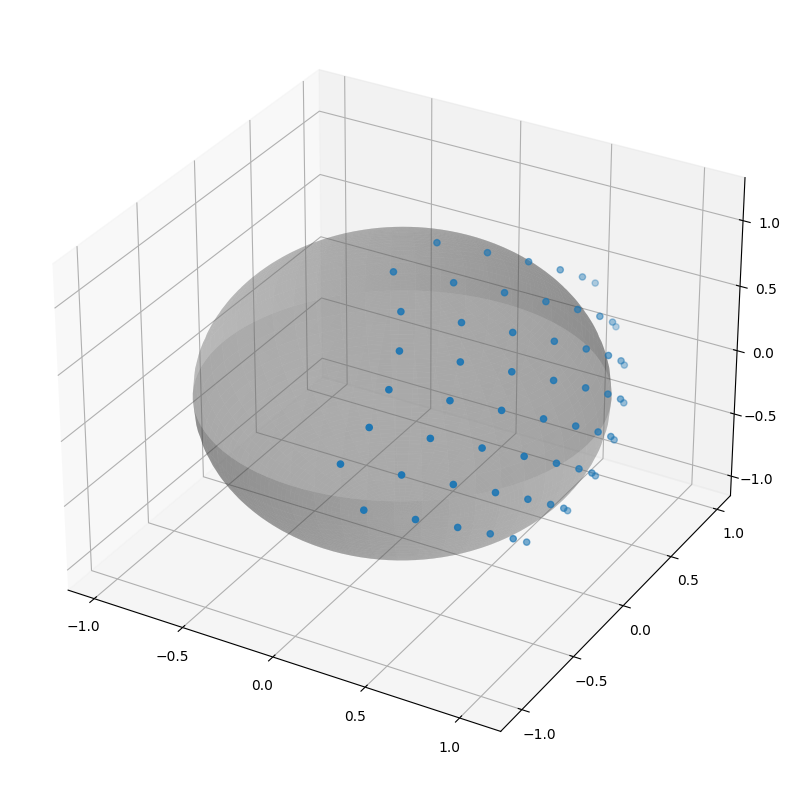

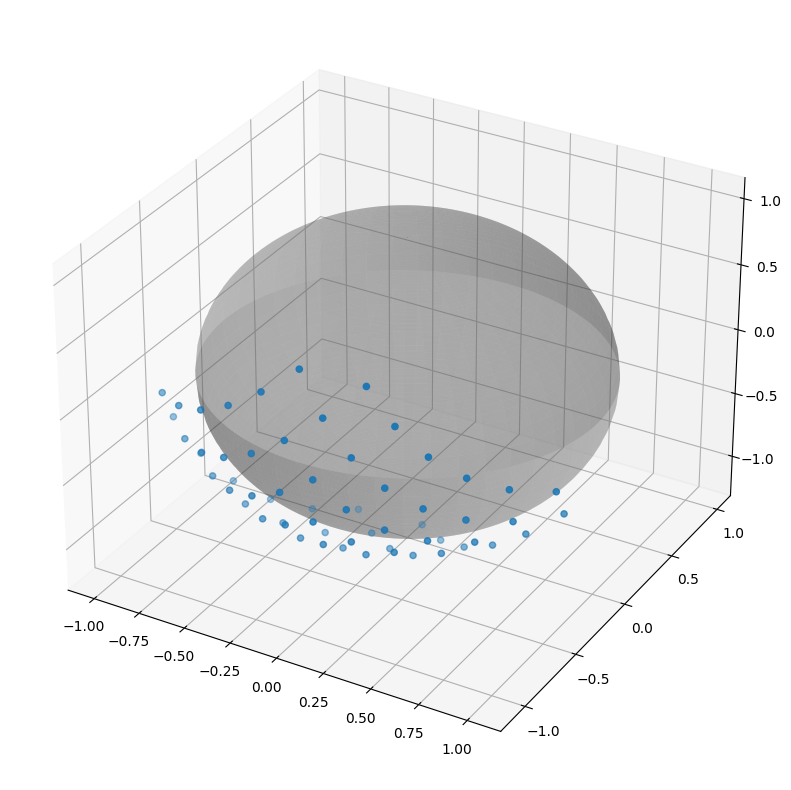

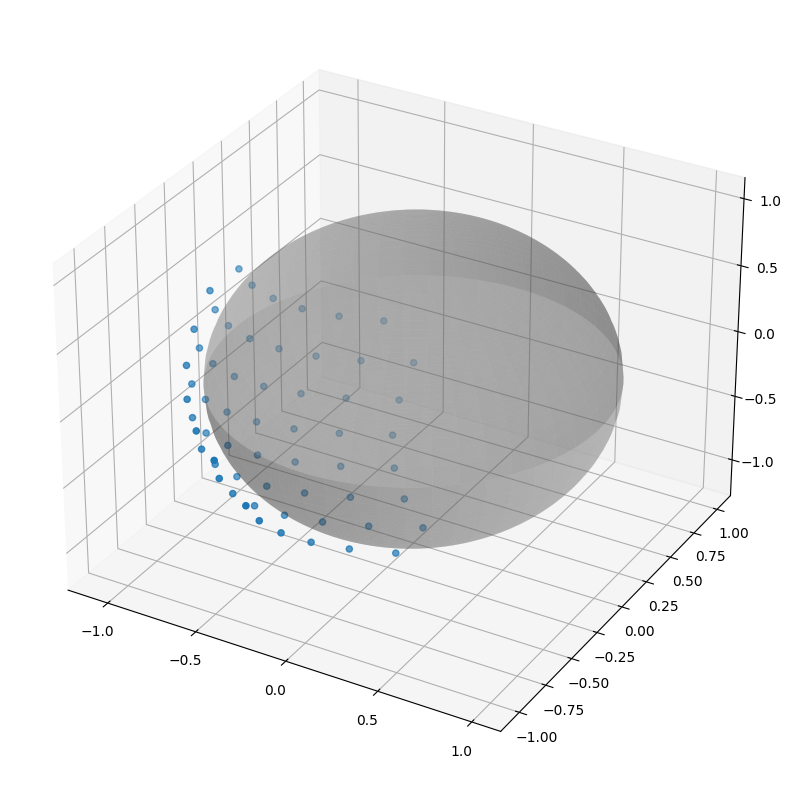

In [11]:
for ind in range(10):
    draw_chart_on_sphere(ind)